In [10]:
import os
data_dir = '../datasets/flowers'

os.listdir(data_dir)

['daisy', 'dandelion', 'tulip', 'rose', 'sunflower']

In [11]:
import torchvision

basic_transformer = torchvision.transforms.Compose(
    [   
     torchvision.transforms.Resize((224, 224)),
     torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize(
         mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]
     ),
    ]
)

In [12]:
from torchvision.datasets import ImageFolder

flower_dataset = ImageFolder(data_dir, transform = basic_transformer)
print(len(flower_dataset), flower_dataset.classes)

4337 ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']


In [13]:
import pytorch_lightning as pl
import torch

from torchvision.transforms import transforms

from torch.utils.data import DataLoader, random_split

class FlowerDataModule(pl.LightningDataModule):
    def __init__(self, data_dir='../datasets/flowers/'):
        super().__init__()

        self.data_dir = data_dir
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.1),
            transforms.RandomRotation(10),
            transforms.ToTensor(),
            transforms.Normalize(
                mean = [0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
            )
        ])

    def setup(self, stage=None):
        flower_full = ImageFolder(self.data_dir, transform=self.transform)

        length = len(flower_full)

        val_split_size = 0.2
        train_length = round(length * (1-val_split_size))
        val_length = length - train_length

        self.flower_train, self.flower_val = \
          random_split(flower_full, [train_length, val_length])
        
    def train_dataloader(self):
        train_dataloader = DataLoader(self.flower_train, batch_size=16, shuffle=True, drop_last=True)
        return train_dataloader
    
    def val_dataloader(self):
        val_dataloader = DataLoader(self.flower_val, batch_size=16, drop_last=True)
        return val_dataloader


In [14]:
flower_dm = FlowerDataModule()
flower_dm.setup()

train_dl = flower_dm.train_dataloader()
val_dl = flower_dm.val_dataloader()

print(len(train_dl), len(val_dl))

216 54


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


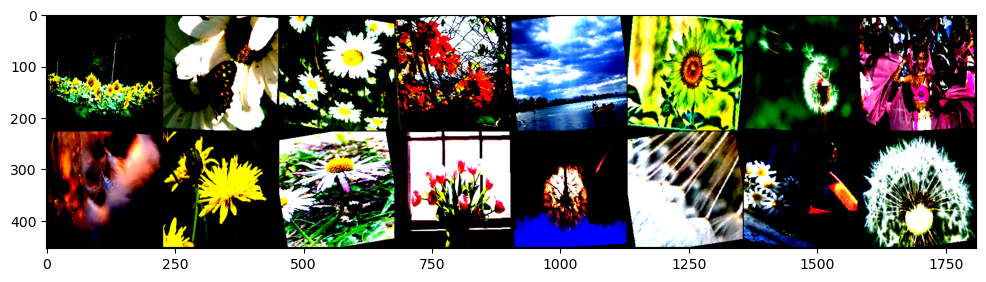

In [15]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

def show_batch_images(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize = (12, 6))
        ax.imshow(make_grid(images, nrow = 8).permute(1, 2, 0))
        break

show_batch_images(train_dl)

In [16]:
from torchvision import models 
from torch.nn.functional import cross_entropy
from torch.optim import Adam
from torchmetrics.functional import accuracy

class FlowerImageClassifier(pl.LightningModule):
    def __init__(self, num_classes = 5, lr=1e-3):
        super().__init__()
        self.save_hyperparameters()

        self.backbone = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        self.finetune_layer = torch.nn.Linear(
            self.backbone.fc.out_features, num_classes
        )

    def training_step(self, batch, batch_idx):
        x, y = batch

        with torch.no_grad():
            features = self.backbone(x)
        
        preds = self.finetune_layer(features)

        loss = cross_entropy(preds, y)
        accuracy_score = accuracy(preds, y, task='multiclass', num_classes=self.hparams.num_classes)

        metrics = {'train_loss': loss,
                   'train_acc': accuracy_score}
        self.log_dict(metrics, on_step=False, on_epoch=True,
                      prog_bar=True, logger=True)
        
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch

        features = self.backbone(x)
        preds = self.finetune_layer(features)

        loss = cross_entropy(preds, y)
        accuracy_score = accuracy(preds, y, task='multiclass', num_classes=self.hparams.num_classes)

        metrics = {'val_loss': loss, 'val_acc': accuracy_score}
        self.log_dict(metrics, on_step=False, on_epoch=True,
                      prog_bar=True, logger=True)
        
        return metrics
    
    def configure_optimizers(self):
        optimizer = Adam(self.parameters(), lr=self.hparams.lr)
        return optimizer

In [17]:
from pytorch_lightning.loggers import CSVLogger

logger = CSVLogger(save_dir='./lightning_logs', name='resnet50_frozen_bb')

In [18]:
classifier = FlowerImageClassifier()

trainer = pl.Trainer(max_epochs=20, logger=logger)
trainer.fit(classifier, flower_dm)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type   | Params | Mode 
--------------------------------------------------
0 | backbone       | ResNet | 25.6 M | train
1 | finetune_layer | Linear | 5.0 K  | train
--------------------------------------------------
25.6 M    Trainable para

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/heitor/miniforge3/envs/mo433/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=21` in the `DataLoader` to improve performance.
/home/heitor/miniforge3/envs/mo433/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=21` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


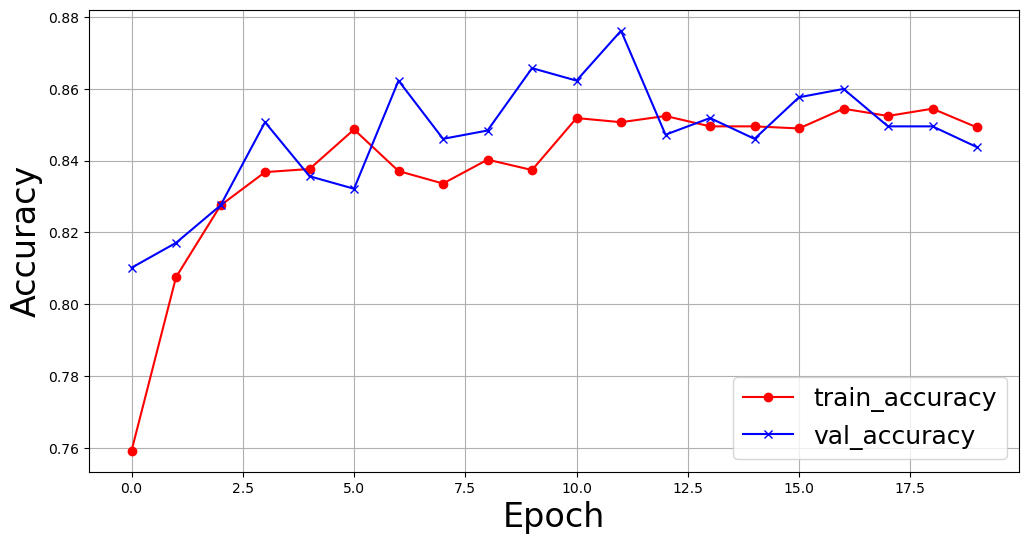

In [19]:
import pandas as pd
metrics = pd.read_csv(f'{trainer.logger.log_dir}/metrics.csv')

train_loss = metrics['train_loss'].dropna().reset_index(drop=True)
train_acc = metrics['train_acc'].dropna().reset_index(drop=True)
valid_loss = metrics['val_loss'].dropna().reset_index(drop=True)
valid_acc = metrics['val_acc'].dropna().reset_index(drop=True)

fig = plt.figure(figsize = (12, 6))
plt.grid(True)

plt.plot(train_acc, color = 'r', marker = 'o', label = 'train_accuracy')
plt.plot(valid_acc, color = 'b', marker = 'x', label = 'val_accuracy')

plt.ylabel('Accuracy', fontsize = 24)
plt.xlabel('Epoch', fontsize = 24)

plt.legend(loc = 'lower right', fontsize = 18)
plt.savefig(f'{trainer.logger.log_dir}/acc_sup1.png')